In [17]:
import pandas as pd
import seaborn as sns

from math import floor
from copy import deepcopy

import random

In [18]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [13]:
# Установка библиотеки sklearn
!pip3 install sklearn

  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for sklearn: started
  Running setup.py install for sklearn: finished with status 'done'


  DEPRECATION: sklearn is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: C:\Users\sasha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [45]:
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'

In [17]:
class ShuffleOnceRandom():
    """
    Генератор случайных чисел, который запрещает использовать
    функцию shuffle больше одного раза.
    """
    
    def __init__(self, seed=None):
        import random
        
        self._random_gen = random.Random(seed)
        self._shuffle_cnt = 0
        
    def shuffle(self, l):
        if self._shuffle_cnt > 0:
            raise RuntimeError('Нельзя использовать функцию shuffle больше одного раза')
            
        self._shuffle_cnt += 1
        self._random_gen.shuffle(l)

In [23]:
class ChoicesNRandom():
    """
    Генератор случайных чисел, который запрещает использовать
    функцию choices больше n раз.
    """
    
    def __init__(self, seed=None, n=1):
        import random
        
        self._random_gen = random.Random(seed)
        self._choices_cnt = 0
        self._n = n
        
    def choices(self, *args, **kwargs):
        if self._choices_cnt >= self._n:
            raise RuntimeError(f'Нельзя использовать функцию choices больше {self._n} раз')
            
        self._choices_cnt += 1
        return self._random_gen.choices(*args, **kwargs)

# Разбиение на обучающую, валидационную и тестовую выборки

In [37]:
def train_test_split_solution(data, 
                              train_frac,
                              random_gen):
    """
    Разбивает переданный список объектов на обучающую и тестовую выборки.
    
    Аргументы:
        data: Список объектов, который нужно разделить на части.
        train_frac: Доля объектов, которые нужно отправить в обучающую выборку.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Пара списков: обучающая выборка, тестовая выборка.
    """
    
    l = deepcopy(data)
    random_gen.shuffle(l)

    count = floor(len(l) * train_frac)
    
    learn = []
    for i in range(count):
        learn.append(l[i])
        
    test = []
    for i in range(count, len(l)):
        test.append(l[i])
    
    
    return learn, test
    

In [38]:
def train_test_split_tests():
    example_1_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    example_1_train_frac = 0.7
    example_1_random_gen = ShuffleOnceRandom(0)
    
    example_1_res = [8, 9, 2, 6, 4, 5, 3], [1, 10, 7]
    
    assert train_test_split_solution(example_1_data, 
                                     example_1_train_frac, 
                                     example_1_random_gen) == example_1_res
    
    
    example_2_data = [i % 5 for i in range(100)]
    example_2_train_frac = 0.9
    example_2_random_gen = ShuffleOnceRandom(0)
    
    example_2_res = [3, 3, 1, 2, 3, 3, 1, 1, 4, 4, 1, 3, 2, 1, 0, 2, 2, 2, 3, 1, 4, 1, 4, 0, 4, 0, 2, 4, 3, 2, 3, 1, 3, 4, 1, 3, 4, 3, 4, 4, 4, 0, 4, 0, 0, 1, 1, 1, 2, 2, 3, 0, 4, 0, 3, 1, 1, 0, 2, 0, 3, 2, 3, 0, 1, 0, 1, 0, 0, 4, 0, 1, 0, 2, 4, 2, 4, 3, 2, 3, 2, 4, 2, 0, 1, 2, 4, 2, 4, 0], [1, 3, 1, 2, 0, 3, 0, 3, 2, 4]
    
    assert train_test_split_solution(example_2_data, 
                                     example_2_train_frac, 
                                     example_2_random_gen) == example_2_res
    
    print('Все тесты прошли успешно!')

In [39]:
train_test_split_tests()

Все тесты прошли успешно!


# Кросс-валидация

In [20]:
def round_to_3(x):
    """
    Принимает число и возвращает результат его округления
    до 3 знаков после запятой.
    
    Аргументы:
        x: Число.
        
    Возвращаемое значение:
        Результат округления числа до 3 знаков после запятой.
    """
    
    return round(x, 3)

In [41]:
def split_into_k(l, k):
    """
    Разделяет список на k частей.
    
    Аргументы:
        l: Список с объектами.
        k: Число частей, на которые нужно разделить список.
        
    Возвращаемое значение:
        Возвращает список из k частей исходного списка.
    """
    
    l_mod_k = len(l) % k
    l_div_k = len(l) // k
    
    res = []
    
    for i in range(k):
        res.append(l[i * l_div_k:(i + 1) * l_div_k])
        
    for i in range(l_mod_k):
        res[i].append(l[l_div_k * k + i])
        
    return res

def score_model(model, x_test, y_test):
    """
    Оценивает точность модели по метрике «среднее отклонение от предсказанного значения».
    
    Аргументы:
        model: Модель.
        x_test: Список объектов тестовой выборки.
        y_test: Список значений предсказываемой характеристики для объектов из тестовой выборки.
                Значение на $i$-ой позиции в списке соответствует $i$-ому объекту тестовой выборки.
        
    Возвращаемое значение:
        Точность модели.
    """
    
    y_pred = model.predict(x_test)
    
    res = 0

    for i in range(len(y_test)):
        res += abs(y_pred[i] - y_test[i])
        
    return res / len(y_test)

In [42]:
def k_fold_solution(model, data_x, data_y, k, random_gen):
    """
    Проводит кросс-валидацию заданной модели методом k-Fold.
    
    Аргументы:
        model: Модель, точность которой нужно оценить с помощью кросс-валидации.
        data_x: Список объектов, на основе которых нужно построить модель.
                Каждый объект представлен списком значений факторов.
        data_y: Список значений предсказываемой величины для каждого из объектов.
                На $i$-ой позиции в списке data_y находится предсказываемое
                значение для $i$-го объекта из списка data_x.
             k: Количество частей, на которые нужно разбить данные при кросс-валидации.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Усреднённая по всем итерациям k-Fold точность модели.
    """
    
    data_xy = list(zip(data_x, data_y))
    random_gen.shuffle(data_xy)
    dt_x = []
    dt_y = []
     #for i in range(data_xy):
    #    for j in range(1):
    for i in range(len(data_xy)):
        dt_x.append(data_xy[i][0][0])
        dt_y.append(data_xy[i][1])

    print(dt_x)
    test_x = split_into_k(dt_x, k)
    study_x = []
    study_y = []
    for i in range(k):
        for j in range(k):
            if j != i:
                study_x
                study_y
                model.fit(test_x[j], dt_y[j])
    
    #print(test_x)

    #print(data_x, data_y)
    #print(split_into_k(data_x, k))
    model.fit(data_x, data_y)
    #print(split_into_k(data_x, k))
    #print(score_model(model, data_x, data_y))
    return 0.0

In [43]:
def k_fold_test():
    data_x_example_1 = [[1], [2], [3]]
    data_y_example_1 = [1, 2, 3]
    
    assert k_fold_solution(LinearRegression(), 
                           data_x_example_1, data_y_example_1, 3, 
                           ShuffleOnceRandom(0)) == 0.0
    
    data_example_2 = pd.read_csv('k_fold_test_data.csv')
    
    data_x_example_2 = [[x] for x in list(data_example_2['x'])]
    data_y_example_2 = list(data_example_2['y'])
    
    assert k_fold_solution(LinearRegression(), 
                           data_x_example_2, data_y_example_2, 100, 
                           ShuffleOnceRandom(0)) == 0.602
    
    print('Тест прошёл успешно!')

In [44]:
k_fold_test()

NameError: name 'LinearRegression' is not defined

# Погрешность оценки качества

In [5]:
error_modeling_data = pd.read_csv('error_modelling.csv')

In [6]:
y = list(error_modeling_data['y'])
y_pred = list(error_modeling_data['y_pred'])

In [7]:
y_and_y_pred = list(zip(y, y_pred))

0.004297378049122003
0.7266013205716583


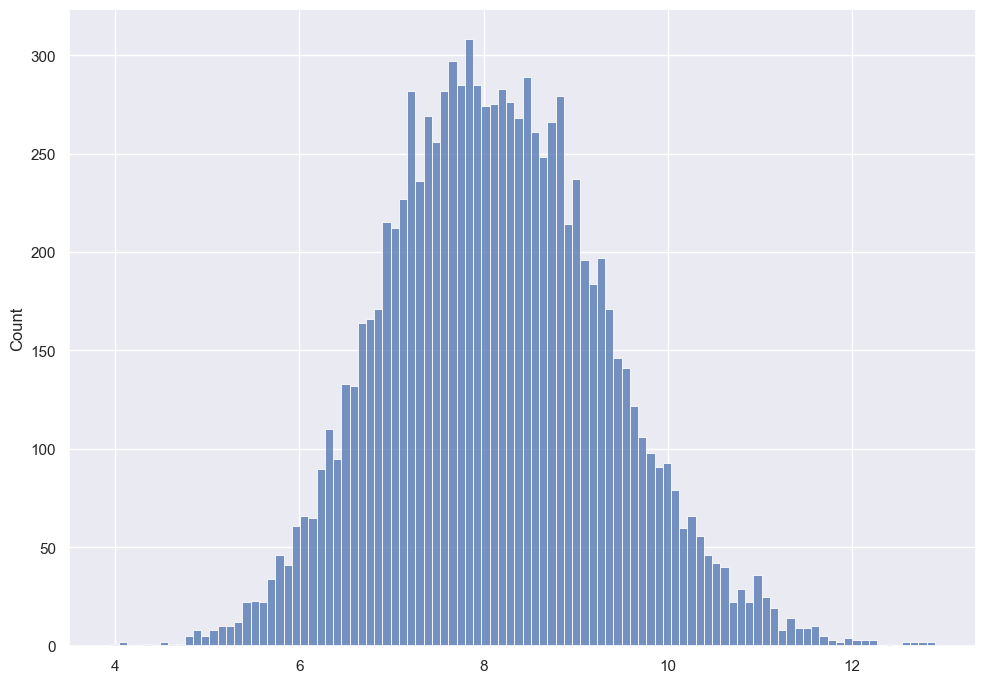

In [8]:
error_modeling_random_gen = random.Random(0)

errs = []

for i in range(10_000):
    # необходимо сгенерировать случайную выборку объектов исходного множества
    # и оценить точность работы модели на этой выборке
    
    data = error_modeling_random_gen.sample(y_and_y_pred, 100)
    summ = 0
    for x, pred in data:
        summ += pred - x
        
    errs.append(summ / 100)
    
sns.histplot(errs, bins = 100)

summ_2 = 0
for i in range(len(y_and_y_pred)):
    summ_2 += y_and_y_pred[i][1] - y_and_y_pred[i][0]

midl = summ_2 / len(y_and_y_pred)

print(abs((sum(errs) / len(errs)) - ( summ_2 / len(y_and_y_pred))))

midler = sum(errs) / len(errs)
summ_3 = 0
for i in range(len(errs)):
    summ_3 += (errs[i] - midler) ** 2
    
print((summ_3 / len(errs)) ** 1/2)

# Бутстрап

In [29]:
def cut_on_edges(l, fraction_to_cut):
    """
    Отбрасывает с левого и с правого концов переданного списка заданную долю элементов.
    
    Аргументы:
        l: Список элементов.
        fraction_to_cut: Доля элементов, которую нужно отбросить с каждой из сторон списка.
        
    Возвращаемое значение:
        Новый список, в котором с левого и с правого концов отборешна заданная доля элементов.
    """
    
    to_cut = floor(len(l) * fraction_to_cut)
    return l[to_cut:len(l) - to_cut]

In [48]:
def bootstrap_confidence_interval_solution(y, y_pred, fraction_to_cut, random_gen):
    """
    Вычисляет доверительный интервал для точности модели на тестовой выборке с помощью бутстрапа.
    
    Аргументы:
        y: Реальные значения предсказываемой характеристики для объектов тестовой выборки.
        y_pred: Предсказанные с помощью модели значения характеристики для объектов тестовой выборки.
                $i$-ый элемент списка y_pred соответствует предсказанию моделью
                значения под номером $i$ в списке y.
        fraction_to_cut: Доля элементов, которую нужно отбросить с каждого из концов списка полученных с помощью
                         бутстрапа значений перед получением доверительного интервала.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Доверительный интервал для точности модели, оценённой по метрике
        «среднее отклонение от предсказанного значения».
ъ
Представляется в виде пары значений: левая граница интервала, правая граница интервала.
    """ 
    
    y_y_pred = list(zip(y, y_pred))
    choice = []
    ans = []
    summ = 0
    
    for i in range(10000):
            choice = random_gen.choices(y_y_pred, k = len(y_y_pred))
            for y1, y1_pred in choice:
                summ += abs(y1 - y1_pred)
                
            ans.append(summ / len(choice))
            summ = 0
    ans.sort()
    ans = cut_on_edges(ans, fraction_to_cut)
    
    return round_to_3(ans[0]), round_to_3(ans[len(ans) - 1])

In [49]:
def bootstrap_confidence_interval_test():
    error_modeling_data = pd.read_csv('error_modelling.csv')
    
    y = list(error_modeling_data['y'])
    y_pred = list(error_modeling_data['y_pred'])
    
    y_y_pred = list(zip(y, y_pred))
    
    random_gen = random.Random(0)
    y_y_pred_example_1 = random_gen.sample(y_y_pred, 100)
    
    y_example_1 = [x[0] for x in y_y_pred_example_1]
    y_pred_example_1 = [x[1] for x in y_y_pred_example_1]
    random_gen_example_1 = ChoicesNRandom(0, n=10000)
    
    res_example_1 = 7.178, 13.509
    
    assert bootstrap_confidence_interval_solution(y_example_1, y_pred_example_1, 0.025, random_gen_example_1) == res_example_1
    
    print('Тест прошёл успешно!')

In [50]:
bootstrap_confidence_interval_test()

[7.177898231881336, 7.179625572572518, 7.189640099385307, 7.194209982456581, 7.203228137189171, 7.2032748448482256, 7.2057587590508065, 7.209108595452438, 7.2167079844973925, 7.218470187216414, 7.22067198189753, 7.223135658966368, 7.226054477877065, 7.227405105025616, 7.22854574443139, 7.229620902612653, 7.231661986229532, 7.232431148147966, 7.233779879193119, 7.234304163766276, 7.237190994865164, 7.238220409727123, 7.238792262652316, 7.241628860068752, 7.2442654530220025, 7.244365266519985, 7.244681774868004, 7.245483135332359, 7.248846339635915, 7.25249175595658, 7.254094109047487, 7.254814229599783, 7.254891919354013, 7.257950205524115, 7.2612863234793, 7.26168414076383, 7.264458719524956, 7.264711422609032, 7.26763348917245, 7.2679828861726, 7.268069312142293, 7.269629339149597, 7.269869517460534, 7.273766779884022, 7.27849282704489, 7.281563898413683, 7.284650210400474, 7.285281213470021, 7.287389053675817, 7.289774819271737, 7.291666830903955, 7.293986172444688, 7.294304255241285